Reference notebook : [Link](https://github.com/tomasonjo/blogs/blob/master/lp-combiner/Link%20prediction%20combiner.ipynb)

In [2]:
from neo4j import GraphDatabase
import pandas as pd
from dotenv import load_dotenv
import os

In [9]:
load_dotenv(override=True)

True

In [10]:
uri = os.getenv('uri')
user = os.getenv('user')
passw = os.getenv('password')

In [5]:
def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [12]:
driver = GraphDatabase.driver(uri,auth=(user, passw))

In [13]:
# Import data to neo4j
run_query("""
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/got-s1-edges.csv" as row
MERGE (s:Character{name:row.Source})
MERGE (t:Character{name:row.Target})
MERGE (s)-[i:INTERACTS]-(t)
SET i.weight = toInteger(row.Weight)
""")

""


Link prediction pipeline Under the hood, the link prediction model in Neo4j uses a logistic regression classifier. We are dealing with a binary classification problem, where we want to predict if a link exists between a pair of nodes or not. On a high level, the link prediction pipeline follows the following steps:

1. Node Feature engineering
2. Link Feature combiner
3. Model training
4. Predict new links

In [14]:
# Project the graph
run_query("""
CALL gds.graph.project('gots1', 'Character', {INTERACTS:{orientation:'UNDIRECTED', properties:'weight'}})
""")
# INTERACTS is the relationship type, we can define its orientation and also choose the properties

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Character': {'label': 'Character', 'properti...","{'INTERACTS': {'orientation': 'UNDIRECTED', 'a...",gots1,126,1098,216


In [15]:
# Use louvain algorithm
run_query("""
CALL gds.louvain.write('gots1', {writeProperty:'louvain', relationshipWeightProperty:'weight'})
""")
# we are writing it back to the database as we are using write

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,301,126,0.528858,"[0.5016739965172651, 0.5288576612285539]",2,7,"{'p99': 45, 'min': 2, 'max': 45, 'mean': 18.0,...",494,1,1794,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [16]:
# Executing the FastRP algorithm
run_query("""
CALL gds.fastRP.write('gots1', {writeProperty:'embedding', embeddingDimension:56, relationshipWeightProperty:'weight'})
""")

,nodeCount,nodePropertiesWritten,preProcessingMillis,computeMillis,writeMillis,configuration
0,126,126,1,79,202,"{'writeConcurrency': 4, 'nodeSelfInfluence': 0..."


In [17]:
# Use TSNE to visualize embeddings
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns


def tsne(embeddings, hue=None):
    tsne = TSNE(n_components=2, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings['embedding'].to_list())

    embeddings['tsne_x'] = [x[0] for x in list(tsne_results)]
    embeddings['tsne_y'] = [x[1] for x in list(tsne_results)]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne_x", y="tsne_y",
        hue=hue,
        palette="deep",
        data=embeddings,
        legend="full",
        alpha=0.9
    )
    # Add captions
    #for i in range(embeddings.shape[0]):
    #    plt.text(x=embeddings['tsne_x'][i]+0.3,y=embeddings['tsne_y'][i]+0.3,s=embeddings.character[i], 
    #          fontdict=dict(color='black',size=10),)

In [18]:
tsne_input = run_query("""
MATCH (c:Character)
RETURN c.name as character, c.embedding as embedding, c.louvain as hue 
""")

In [20]:
tsne_input.head()
# We can store these embeddings, use them further etc.

,character,embedding,hue
0,NED,"[0.1140875369310379, -0.5276080369949341, 0.21...",10
1,DAENERYS,"[-0.015274729579687119, 0.1534349024295807, 0....",18
2,JON,"[0.046653248369693756, -0.5181201100349426, -0...",102
3,LITTLEFINGER,"[0.18625080585479736, -0.5020092725753784, 0.2...",10
4,ARYA,"[0.13581830263137817, -0.49909472465515137, 0....",10


D:\anaconda_dist\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda_dist\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


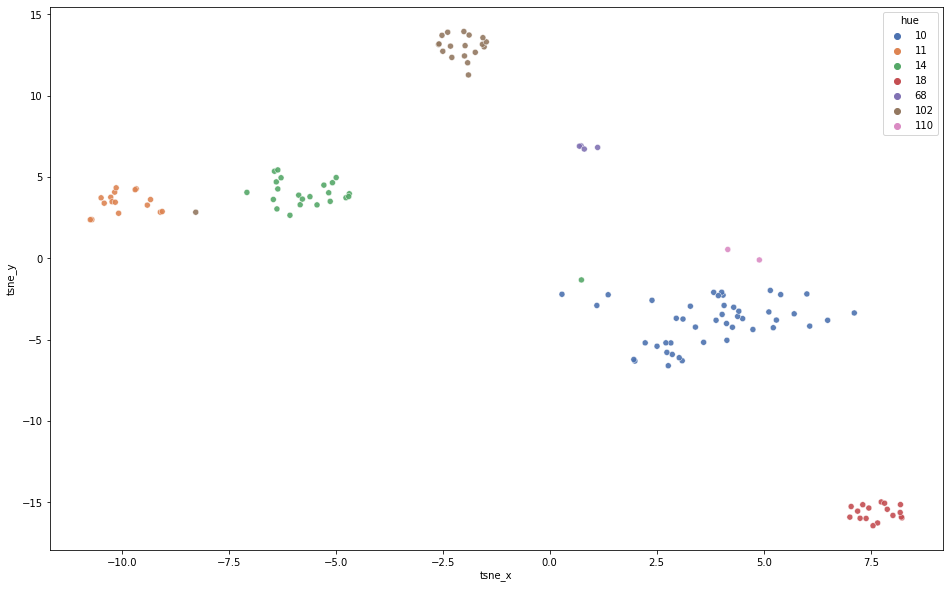

In [21]:
tsne(tsne_input,'hue')
# Here we can see that FastRP embeddings also give similar vectors to nodes in the same community despite of it being run 
# independent to the louvain algorithm. This is no surprise as FastRP is a community-based node embedding algorithm, 
# meaning that nodes close in the graph will be also close in the embedding space.

In [22]:
run_query("""
CALL gds.graph.project('knn', 'Character', '*', {nodeProperties:['embedding']})
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Character': {'label': 'Character', 'properti...","{'__ALL__': {'orientation': 'NATURAL', 'aggreg...",knn,126,549,66


In [23]:
run_query("""
CALL gds.knn.stats('knn', {nodeProperties:'embedding', topK: 1000, similarityCutoff:0.1})
YIELD similarityDistribution
""")['similarityDistribution'][0]

{'p1': 0.38733673095703125,
 'max': 1.0000057220458984,
 'p5': 0.4079093933105469,
 'p90': 0.9785747528076172,
 'p50': 0.6908588409423828,
 'p95': 0.9897670745849609,
 'p10': 0.4675788879394531,
 'p75': 0.8595676422119141,
 'p99': 0.9977779388427734,
 'p25': 0.5612850189208984,
 'p100': 1.0000057220458984,
 'min': 0.3769645690917969,
 'mean': 0.7070677114819723,
 'stdDev': 0.18397122248203882}

In [24]:
df = run_query("""
MATCH (c1:Character)-[:INTERACTS]->(c2:Character)
RETURN gds.similarity.euclideanDistance(c1.embedding, c2.embedding) AS distance, 'euclidian' as metric
UNION
MATCH (c1:Character)-[:INTERACTS]->(c2:Character)
RETURN gds.similarity.cosine(c1.embedding, c2.embedding) AS distance, 'cosine' as metric
""")

In [27]:
df.sample(5)

,distance,metric
492,0.696755,euclidian
294,0.146383,euclidian
1012,0.823853,cosine
239,0.483534,euclidian
559,0.738395,cosine


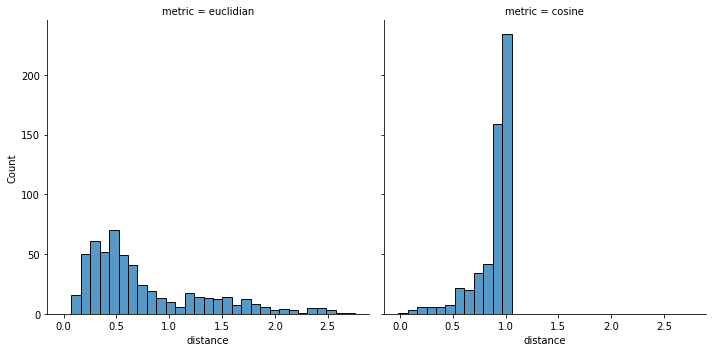

In [28]:
sns.displot(data=df, x='distance', col='metric')

In [39]:
len(df[df['metric']=='cosine'][df['distance']>0.7]) # and there are 549 edges
# This means that most of the node pairs that have an edge have similar embeddings
# As we can see 468/549 node pairs have embeddings cosine similarity/ dot product > 0.7
# 425/549 (77%) of them have cosine similarity > 0.8
# 380/549 (69%) of them have cosine similarity > 0.9
# 213/549 (38%) of them have cosine similarity > 0.97

C:\Users\aakash\AppData\Local\Temp/ipykernel_4564/2107066233.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[df['metric']=='cosine'][df['distance']>0.7]) # and there are 549 edges


468

In [29]:
run_query("""
MATCH p=(c1:Character)-[i:INTERACTS]->(c2:Character)
WHERE gds.similarity.cosine(c1.embedding, c2.embedding) < 0.5
SET i.show = True
""")

""


It seems that pairs of connected nodes with a lower cosine similarity mainly occur when we have connections between various clusters or communities in the network.

In [54]:
not_similar = run_query("""
MATCH (c1:Character)-[:INTERACTS]->(c2:Character)
WITH c1 , c2 
WITH gds.similarity.cosine(c1.embedding, c2.embedding) as cosine_distance,c1.name as c1name, c2.name as c2name
WHERE cosine_distance<0.3
RETURN cosine_distance, c1name, c2name
""")

In [55]:
not_similar

,cosine_distance,c1name,c2name
0,0.113982,JORAH,NED
1,0.149135,DAENERYS,NED
2,-0.017000,CATELYN,DAENERYS
3,0.263767,JEOR,JOFFREY
4,0.189686,DAENERYS,SANSA
5,0.253246,AERYS,JORAH
6,0.142340,NED,PYP
7,0.174631,DROGO,ROBERT
8,0.265020,JEOR,ROBERT
9,0.197297,DAENERYS,ROBERT


In [56]:
# Cosine combiner
def generate_links(combiner, predictedRelType):
    # Delete all graph models & drop all named graphs
    run_query("""
    CALL gds.graph.list() YIELD graphName
    CALL gds.graph.drop(graphName) YIELD graphName as done
    RETURN distinct 'dropped named graphs' as result
    UNION
    CALL gds.beta.model.list() YIELD modelInfo
    CALL gds.beta.model.drop(modelInfo.modelName) YIELD modelInfo as done
    RETURN distinct 'dropped ML models' as result
    UNION 
    CALL gds.beta.pipeline.list() YIELD pipelineName
    CALL gds.beta.pipeline.drop(pipelineName) YIELD pipelineName AS done
    RETURN distinct 'dropped pipelines' AS result
    """)
    # Define a new LP pipeline
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.create('lp-pipeline')
    """)
    # Define feature combiner
    run_query(f"""
    CALL gds.beta.pipeline.linkPrediction.addFeature('lp-pipeline', '{combiner}', {{
      nodeProperties: ['embedding']
    }}) YIELD featureSteps;
    """)
    # Define train-test split
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.configureSplit(
     'lp-pipeline', {  
       testFraction: 0.3,
       trainFraction: 0.6,
       validationFolds: 7})
    YIELD splitConfig;
    """)
    # Configure LP model params
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.addLogisticRegression(
      'lp-pipeline',  
        {tolerance: 0.001, maxEpochs: 500})
    YIELD parameterSpace;
    """)
    # Add multiple models
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.addLogisticRegression(
      'lp-pipeline',  
        {penalty:0.001, tolerance: 0.01,  maxEpochs: 500})
    YIELD parameterSpace;
    """)
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.addLogisticRegression(
      'lp-pipeline',  
        {penalty:0.01, tolerance: 0.01, maxEpochs: 500})
    YIELD parameterSpace;
    """)
    # Construct named graph
    run_query("""
    CALL gds.graph.project('lp-graph', 
      'Character', 
      {INTERACTS:{orientation:'UNDIRECTED'}},
      {nodeProperties:'embedding'});
    """)
    # Train the model
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.train('lp-graph', 
  {pipeline: 'lp-pipeline',
   modelName: 'lp-model',
   randomSeed: 42})
    YIELD modelInfo
    RETURN  modelInfo.bestParameters AS winningModel,  modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,  modelInfo.metrics.AUCPR.test AS testGraphScore;
    """)
    # Predict new relationships
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.predict.mutate('lp-graph', 
      {modelName: 'lp-model',  
       mutateRelationshipType: 'INTERACTS_PREDICTED',
       topN: 20,
       threshold: 0.45})
    YIELD relationshipsWritten;
    """)
    # Store relationships back to graph
    predicted_links = run_query(f"""
    CALL gds.graph.streamRelationshipProperty('lp-graph', 
      'probability', 
      ['INTERACTS_PREDICTED'])
    YIELD  sourceNodeId, targetNodeId, propertyValue as probability
    WHERE sourceNodeId < targetNodeId
    MATCH (s),(t)
    WHERE id(s)=sourceNodeId AND id(t)=targetNodeId
    MERGE (s)-[:{predictedRelType}]-(t)
    RETURN avg(gds.similarity.euclideanDistance(s.embedding, t.embedding)) AS euclidian_similarity,
           avg(gds.similarity.cosine(s.embedding, t.embedding)) AS cosine_similarity
           
    """)
    return predicted_links

In [58]:
generate_links('cosine', 'PREDICTED_COSINE')

,euclidian_similarity,cosine_similarity
0,0.051254,0.999454


In [59]:
generate_links('l2', 'PREDICTED_L2')

,euclidian_similarity,cosine_similarity
0,0.045057,0.999341


In [60]:
generate_links('hadamard', 'PREDICTED_HADAMARD')

,euclidian_similarity,cosine_similarity
0,0.207243,0.994216


In [61]:
# Multiple link feature combiners
def generate_pa_links(combiner, predictedRelType, scale=True):
    # Delete all graph models & drop all named graphs
    run_query("""
    CALL gds.graph.list() YIELD graphName
    CALL gds.graph.drop(graphName) YIELD graphName as done
    RETURN distinct 'dropped named graphs' as result
    UNION
    CALL gds.beta.model.list() YIELD modelInfo
    CALL gds.beta.model.drop(modelInfo.modelName) YIELD modelInfo as done
    RETURN distinct 'dropped ML models' as result
    UNION 
    CALL gds.beta.pipeline.list() YIELD pipelineName
    CALL gds.beta.pipeline.drop(pipelineName) YIELD pipelineName AS done
    RETURN distinct 'dropped pipelines' AS result
    """)
    # Define a new LP pipeline
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.create('lp-pipeline')
    """)
    # Get the degree value of each node
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.addNodeProperty('lp-pipeline', 'degree', {
          mutateProperty: 'degree'
    })""")
    if scale:
        # Scale the degree using minmax scaler
        run_query("""
        CALL gds.beta.pipeline.linkPrediction.addNodeProperty('lp-pipeline', 'alpha.scaleProperties', {
              nodeProperties: ['degree'],
              mutateProperty: 'scaledDegree',
              scaler:'MinMax'
        })
        """)
        # Define HADAMARD combiner for node degree combiner
        run_query("""
        CALL gds.beta.pipeline.linkPrediction.addFeature('lp-pipeline', 'HADAMARD', {
          nodeProperties: ['scaledDegree']
        }) YIELD featureSteps;
        """)
    else:
        run_query("""
        CALL gds.beta.pipeline.linkPrediction.addFeature('lp-pipeline', 'HADAMARD', {
          nodeProperties: ['degree']
        }) YIELD featureSteps;""")
        
    # Define feature combiner
    run_query(f"""
    CALL gds.beta.pipeline.linkPrediction.addFeature('lp-pipeline', '{combiner}', {{
      nodeProperties: ['embedding']
    }}) YIELD featureSteps;
    """)
    # Define train-test split
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.configureSplit(
     'lp-pipeline', {  
       testFraction: 0.3,
       trainFraction: 0.6,
       validationFolds: 7})
    YIELD splitConfig;
    """)
    # Configure LP model params
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.addLogisticRegression(
      'lp-pipeline',  
        {tolerance: 0.001, maxEpochs: 500})
    YIELD parameterSpace;
    """)
    # Add multiple models
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.addLogisticRegression(
      'lp-pipeline',  
        {penalty:0.001, tolerance: 0.01,  maxEpochs: 500})
    YIELD parameterSpace;
    """)
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.addLogisticRegression(
      'lp-pipeline',  
        {penalty:0.01, tolerance: 0.01, maxEpochs: 500})
    YIELD parameterSpace;
    """)
    # Construct named graph
    run_query("""
    CALL gds.graph.project('lp-graph', 
      'Character', 
      {INTERACTS:{orientation:'UNDIRECTED'}},
      {nodeProperties:'embedding'});
    """)
    # Train the model
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.train('lp-graph', 
  {pipeline: 'lp-pipeline',
   modelName: 'lp-model',
   randomSeed: 42})
    YIELD modelInfo
    RETURN  modelInfo.bestParameters AS winningModel,  modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,  modelInfo.metrics.AUCPR.test AS testGraphScore;
    """)
    # Predict new relationships
    run_query("""
    CALL gds.beta.pipeline.linkPrediction.predict.mutate('lp-graph', 
      {modelName: 'lp-model',  
       mutateRelationshipType: 'INTERACTS_PREDICTED',
       topN: 20,
       threshold: 0.45})
    YIELD relationshipsWritten;
    """)
    # Store relationships back to graph
    predicted_links = run_query(f"""
    CALL gds.graph.streamRelationshipProperty('lp-graph', 
      'probability', 
      ['INTERACTS_PREDICTED'])
    YIELD  sourceNodeId, targetNodeId, propertyValue as probability
    WHERE sourceNodeId < targetNodeId
    MATCH (s),(t)
    WHERE id(s)=sourceNodeId AND id(t)=targetNodeId
    MERGE (s)-[:{predictedRelType}]-(t)
    RETURN avg(gds.similarity.euclideanDistance(s.embedding, t.embedding)) AS euclidian_similarity,
           avg(gds.similarity.cosine(s.embedding, t.embedding)) AS cosine_similarity
    """)
    return predicted_links

In [62]:
generate_pa_links('cosine', 'PA_COSINE')

,euclidian_similarity,cosine_similarity
0,0.541043,0.959421


In [63]:
generate_pa_links('l2', 'PA_L2')

,euclidian_similarity,cosine_similarity
0,0.052522,0.99897


In [64]:
generate_pa_links('l2', 'PA_L2_NOTSCALED1', False)

,euclidian_similarity,cosine_similarity
0,2.046423,0.396348


In [65]:
generate_pa_links('hadamard', 'PA_HADAMARD')

,euclidian_similarity,cosine_similarity
0,0.222227,0.993236
